# Construire une vérité terrain pour cartographier des objets par deep-learning


Data structure : 

```
data
├── Environment_Agency/Vertical_Photography/bristol/2009/tif_tiles
│   ├── Ortho_IRRGB_P00021599_20090210_20090210_20cm_res.tif
│   ├── Ortho_IRRGB_P00021601_20090210_20090210_20cm_res.tif
├── Environment_Agency/Vertical_Photography/bristol/2012/tif_tiles
│   ├── Ortho_IRRGB_P00047302_20121125_20121125_25cm_res.tif
│   ├── Ortho_IRRGB_P00047304_20121125_20121125_25cm_res.tif
├── OS_OpenMap_Local/Tile_ST_Bristol
│   ├── ST_Building.shp
│   ├── ST_Building.shx
│   json/json_format_building
│   ├── ST_Building.geojson
├── building_footprint_catagories_shapefile_vectors.json
├── building_footprint_catagories_json_vectors.json
```






-----------------------------------

Original notebook

L'objectif de ce notebook est de vous guider dans la construction d'un jeu de données **(images, labels)**, pouvant servir de vérité terrain à un modèle de deep-learning pour la détection d'objets dans des photographies aériennes ou satellitaires. Ce jeu de données est créé à partir d'images géolocalisées (*fichiers rasters*) et de fichiers de géométries (*fichiers vecteurs*). 

Les données utilisées dans ce notebook sont sous license ouverte et proviennent de la plateforme des données de la Métropole de Lyon :
- [orthophotographies 2018](https://data.grandlyon.com/jeux-de-donnees/orthophotographie-2018-metropole-lyon-format-tiff/donnees)
- [emprise des bâtiments](https://data.grandlyon.com/jeux-de-donnees/batiments-metropole-lyon/ressources)
- [parcs et jardins](https://data.grandlyon.com/jeux-de-donnees/parcs-jardins-commune-lyon-v1-0-0/donnees)


Structure de nos données de départ : 

```
data
├── rasters
│   ├── 1843_5174_08_CC46.tif
│   ├── 1844_5173_08_CC46.tif
├── vectors
│   ├── buildings.json
│   ├── vegetation.json
├── categories.json
```

Les étapes nécessaires à la construction de cette vérité terrain correspondent aux fonction disponibles dans le module **`geolabels`** de notre bibliothèque [`geolabel_maker`]() : 

**1. Création des labels à partir des fichiers de géométries** :-> `make_labels()`

**2. Création des fichiers vrt** :-> `make_rasters()`

**3. Création de vignettes 256x256 pixels** :-> `make_tiles()`

**4. Création du fichier d'annotations** :-> `make_annotations()`

In [1]:
# Import des modules de geolabel_maker
from geolabel_maker import geolabels
from geolabel_maker.labels import show

In [2]:
# Import des autres librairies utilisées
from pathlib import Path 
from PIL import Image
import matplotlib.pyplot as plt
import rasterio
from rasterio import plot
from shapely.geometry import box
import geopandas as gpd

In [3]:
# Definition des variables
#dir_rasters = "../../../data/Environment_Agency/Vertical_Photography/bristol/2009/tif_tiles" # Dossier où se trouvent les fichiers tif de l'orthophotographie de Lyon
#dir_rasters = "../../../data/Environment_Agency/Vertical_Photography/bristol/2012/tif_tiles" # Dossier où se trouvent les fichiers tif de l'orthophotographie de Lyon
# dir_rasters = "../../../data/digimap-aerial/2020-Bristol-_1853122/jpeg"
# # dir_rasters = "../../../data/digimap-aerial/2020-Bristol-_1853122/all"
# dir_rasters = "../../../data/digimap-aerial/2020-Bristol-_1853122/tif"
dir_rasters = "../../../data/digimap-aerial/2020-Bristol-_1853122/gtif"

# dir_vectors = "../../../data/OS_OpenMap_Local/Tile_ST_Bristol/shapefile" # shapefile
dir_vectors = "../../../data/OS_OpenMap_Local/Tile_ST_Bristol/json" # json

## 0. Visualisation des données

Avant de préparer nos données pour les algorithmes de deep-learning, commençons par en visualiser le contenu.

### Visualisation des images

Pour visualiser les photographies à notre disposition, nous utilisons simplement la bibliothèque de gestion d'images de Python ([PIL](https://he-arc.github.io/livre-python/pillow/index.html)) et la fonction `imshow()` de Matplotlib.

In [4]:
# Liste des fichiers images à notre disposition
rasters = list(Path(dir_rasters).iterdir())

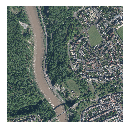

In [5]:
# Visualisation des images
figure= plt.figure(figsize=(12,6))    
columns = 5

for i, raster_file in enumerate(rasters):
    image = Image.open(raster_file)
    plt.subplot(len(rasters) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')

plt.show()

On peut aussi accéder aux caractéristiques spatiales des images avec la bibliothèque [rasterio](https://rasterio.readthedocs.io/en/latest/). Ici, nous sauvegardons les emprises spatiales des images pour les visualiser en même temps que les géométries dont nous disposons. 

In [6]:
# Sauvegarde de l'emprise spatiale des images
rasters_xy = []
for raster_file in rasters :
    raster_data = rasterio.open(raster_file)
    coordinate = raster_data.bounds
    raster_bbox = box(*coordinate)
    rasters_xy.append(raster_bbox.exterior.xy)

### Visualisation des géométries

Pour visualiser les géométries, nous utilisons [geopandas](https://geopandas.org/index.html), une bibliothèque de gestion de données spatiales vectorielles. Le contenu de chaque fichier sera représenté par une couleur que nous définissons ci-dessus. La liste `colors` doit contenir autant de couleurs qu'il n'y a de fichiers dans le dossier `data/vectors/`.

In [7]:
# Définition des couleurs à utiliser pour représenter les différents types de données
# gris --> 1er fichier = bâtiments
# vert --> 2d fichier = végétation
colors = ["#92a9a2", "green"]

In [8]:
# Liste des fichiers de géométries à notre disposition
vectors = Path(dir_vectors).iterdir()

In [9]:
dir_vectors = "../../../data/OS_OpenMap_Local/Tile_ST_Bristol"
# vector_file = "../../../data/OS_OpenMap_Local/Tile_ST_Bristol/shapefile/ST_Building.shp" # shapefile
vector_file = "../../../data/OS_OpenMap_Local/Tile_ST_Bristol/json/ST_Building.geojson" # geojson

vector_data = gpd.read_file(vector_file)

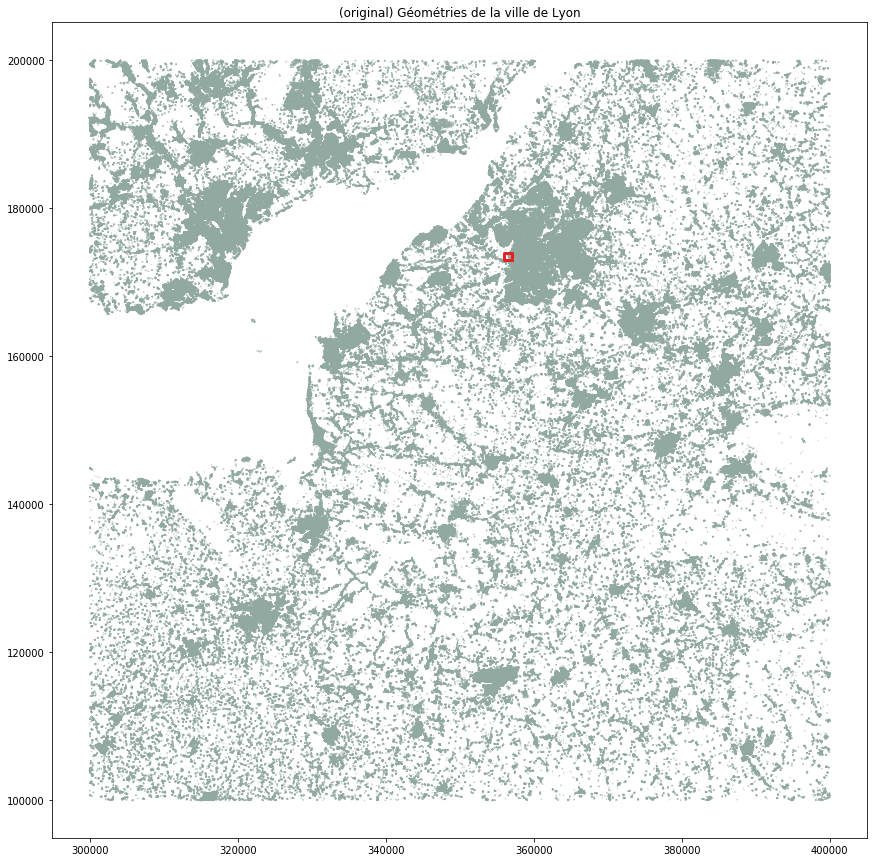

In [10]:
# Visualisation des fichiers vecteurs.
fig,ax=plt.subplots(figsize=(15,15))

for vector_file, color in zip(vectors, colors) :
    # Lecture du fichier vecteur
    vector_data = gpd.read_file(vector_file)    
    # Conversion du systeme de coordonnées pour que toutes les géométries 
    # soient dans le même système que les coordonnées des images.
    vector_data = vector_data.to_crs(raster_data.crs)
    vector_data.plot(color=color, alpha=0.7, ax=ax)
    vector_data.boundary.plot(edgecolor=color, ax=ax)

# Les emprises des images sont représentées par un carré rouge.
for x,y in rasters_xy :
    ax.plot(x, y, color='#e52222',
        linewidth=3, solid_capstyle='round')
    
plt.title("(original) Géométries de la ville de Lyon")
plt.show()

## 1. Création des labels à partir des fichiers de géométries

From the data that we have just represented, we will first of all create “label” images containing the representation of the geometries we have available and the extent of which corresponds to each available image file.

For that, we will specify the geometry files that we want to use, the name of the category of objects to which they correspond, as well as their color of representation in a configuration json file. This file must follow the following structure: :
```
{
  "name_of_category": {
    "id": 1,
    "file": path to your categorie_1 file,
    "color": [255, 255, 255]
  },
}
```
It consists of one information block per file / object category. Within these blocks, each information must be unique, in particular the identifier (id) and the RGB triplet (color) indicating the color to be used.

In [11]:
# Définition de la variable contenant le chemin du fichier json à utiliser

#categories_file = '../data/building_footprint_catagories_shapefile_vectors.json' #shapefile
categories_file = '../data/building_footprint_catagories_json_vectors.json' #json


Les images "labels" sont créées en appelant la fonction `make_labels()`.

In [12]:
import rasterio
#src = rasterio.open('../../../data/Environment_Agency/Vertical_Photography/bristol/2009/tif_tiles/Ortho_IRRGB_P00021599_20090210_20090210_20cm_res.tif')
src = rasterio.open("../../../data/digimap-aerial/2020-Bristol-_1853122/jpeg/st5974_rgb_250_07.jpg")

array = src.read()
array.shape

/home/ot19968/anaconda3/envs/geolabel-maker/lib/python3.6/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(3, 4000, 4000)

In [13]:
# makelabels debug
# geolabels.make_labels(dir_rasters, categories_file)

import json

from geolabel_maker import labels

#----------------

categories = categories_file

## hardcoding 2009 (trimmed tif path to trial)
dir_img = dir_rasters
# dir_img = "../../../data/Environment_Agency/Vertical_Photography/bristol/2009/tif_tiles"

#---------------

print("MAKE LABELS")
# Read json file
with open(categories) as json_file:
    categories_dict = json.load(json_file)

# List images
img_path = Path(dir_img)
rasters = [f for f in img_path.iterdir()]

print(rasters)

# Create the label image associated to the merged raster
# try:
#     for raster in rasters:
#         output_label = labels.make_label(str(raster), categories_dict)
#         print(f"Created label : {output_label}")
# except ValueError:
#     print("Please check your configuration file.")
    
# remove 4th raster dimension to prevent following error
# ValueError: shape mismatch: value array of shape (3,) could not be broadcast to indexing result of shape (1,5000,5000,4)
#[:,:,:3]
    
# outside try
for raster in rasters:
    output_label = labels.make_label(str(raster), categories_dict)
    print(f"Created label : {output_label}")

MAKE LABELS
[PosixPath('../../../data/digimap-aerial/2020-Bristol-_1853122/gtif/st5674_rgb_250_07.tif')]
Created label : ../../../data/digimap-aerial/2020-Bristol-_1853122/gtif/st5674_rgb_250_07-label.tif


In [14]:
path_label = geolabels.make_labels(dir_rasters, categories_file)

MAKE LABELS
Created label : ../../../data/digimap-aerial/2020-Bristol-_1853122/gtif/st5674_rgb_250_07-label.tif
Created label : ../../../data/digimap-aerial/2020-Bristol-_1853122/gtif/st5674_rgb_250_07-label-label.tif


### Visualisation du résultat

Nous pouvons d'ors-et-déjà regarder ici le résultat de la labellisation avec la fonction `show()` disponible dans le module `labels`. Cette étape donne aussi un premier aperçu de la précision de la labellisation.

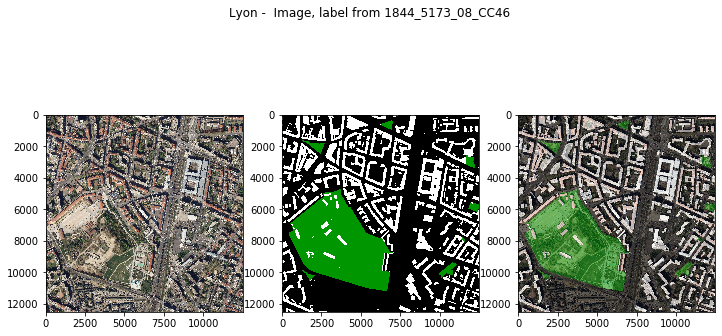

In [15]:
#visualisation des résultats
show(
    '../data/rasters/1844_5173_08_CC46.tif', 
    '../data/rasters/1844_5173_08_CC46-label.tif', 
    img_size=12500, title="Lyon - ", 
    show=True, save=False
)

Il est possible d'obtenir une visualisation plus précise en diminuant la taille (en pixels) de la zone comparée. La partie de l'image sélectionnée est alors choisie ***aléatoirement*** à chaque appel de la fonction.

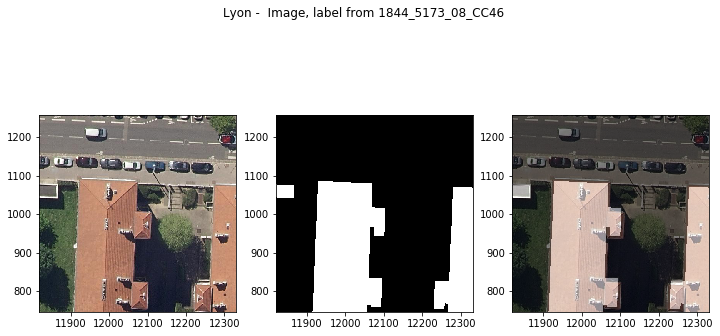

In [16]:
#visualisation des résultats
show(
    '../data/rasters/1844_5173_08_CC46.tif', 
    '../data/rasters/1844_5173_08_CC46-label.tif', 
    img_size=512, title="Lyon - ", 
    show=True, save=False
)

## 2. Création des fichiers vrt

Les images et les labels doivent ensuite être regroupés dans un fichier [VRT](https://gdal.org/drivers/raster/vrt.html) pour permettre le découpage en vignettes. Cette étape est réalisée avec la fonction `make_rasters()`.

In [17]:
images_vrt, labels_vrt = geolabels.make_rasters(dir_rasters)

MAKE VIRTUAL RASTERS
1 images are merged in the file ../../../data/digimap-aerial/2020-Bristol-_1853122/gtif/images.vrt.
2 labels are merged in the file ../../../data/digimap-aerial/2020-Bristol-_1853122/gtif/labels.vrt.


Ces regroupements peuvent être visualisés directement avec les fonctions de la bibliothèque `rasterio`.

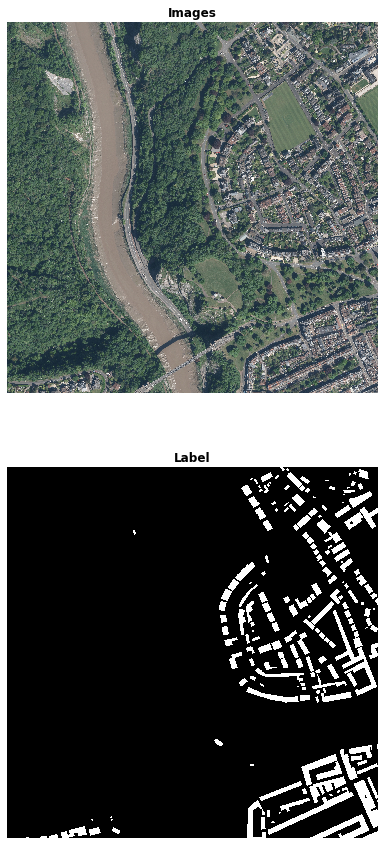

In [18]:
raster_images_vrt = rasterio.open(images_vrt)
raster_labels_vrt = rasterio.open(labels_vrt)

fig, (ax_img, ax_label) = plt.subplots(2,1, figsize=(15,15))

rasterio.plot.show(raster_images_vrt, title="Images", ax=ax_img)
ax_img.axis('off')
rasterio.plot.show(raster_labels_vrt, title="Label", ax=ax_label)
ax_label.axis('off')

raster_images_vrt.close()
raster_labels_vrt.close()

## 3. Création de vignettes 256x256 pixels

Nous pouvons maintenant découper les images et labels dont nous disposons en vignettes de 256x256 pixels. Pour cela, nous créons des tuiles raster à différents niveaux de zoom. 

Avant de lancer cette étape, il est nécessaire de créer un répertoire où seront stockées les vignettes.

In [19]:
dir_tiles = '../data/building_footprint_tiles'

Cette étape est réalisée avec la fonction `make_tiles()`.

In [20]:
geolabels.make_tiles(images_vrt, labels_vrt, dir_tiles)

MAKE TILES
Generating Base Tiles:
0...10...20...30...40...50...60...70...80...90...100
Generating Overview Tiles:
0...10...20...30...40...50...60...70...80...90...100
The image tiles are created in the folder ../data/building_footprint_tiles/images.
Generating Base Tiles:
0...10...20...30...40...50...60...70...80...90...100
Generating Overview Tiles:
0...10...20...30...40...50...60...70...80...90...100
The label tiles are created in the folder ../data/building_footprint_tiles/labels.


Les tuiles sont organisées dans les répertoires `images` et `labels`, et visibles dans un navigateur web grâce aux fichiers `openlayers.html`.

Structure des données créées : 

```
data
├── Environment_Agency/Vertical_Photography/bristol/2009/tif_tiles
│   ├── Ortho_IRRGB_P00021599_20090210_20090210_20cm_res.tif
│   ├── Ortho_IRRGB_P00021601_20090210_20090210_20cm_res.tif
├── Environment_Agency/Vertical_Photography/bristol/2012/tif_tiles
│   ├── Ortho_IRRGB_P00047302_20121125_20121125_25cm_res.tif
│   ├── Ortho_IRRGB_P00047304_20121125_20121125_25cm_res.tif
├── OS_OpenMap_Local/Tile_ST_Bristol
│   ├── ST_Building.shp
│   ├── ST_Building.shx
├── building_footprint_tiles
???
│   ├── images
│   |    ├── 13
│   |    |   ├── 4206
│   |    |   |   ├── 5269.png
│   |    ├── 14
│   |    ├── openlayers.html
│   |    ├── tilemapresource.xml
│   ├── labels
│   |    ├── 13
│   |    |   ├── 4206
│   |    |   |   ├── 5269.png
│   |    ├── 14
│   |    ├── openlayers.html
│   |    ├── tilemapresource.xml
???

├── building_footprint_categories.json
```

![](../medias/openlayers.jpg)

## 4. Création du fichier d'annotations

Enfin, pour certains modèles, il est nécessaire de fournir un fichier descriptif complémentaire au jeu de données. La fonction `make_annotations()` génére un fichier json au format [COCO](http://cocodataset.org/#home).

In [21]:
geolabels.make_annotations(dir_tiles, categories_file, '15')

MAKE ANNOTATIONS
../data/building_footprint_tiles/labels/15/16144/21865.png
../data/building_footprint_tiles/labels/15/16144/21864.png
../data/building_footprint_tiles/labels/15/16145/21865.png
../data/building_footprint_tiles/labels/15/16145/21864.png
The file annotations.json contains your annotations.


Pour contrôler ce fichier, nous vous proposons d'utiliser le notebook [Check_coco_annotations.ipynb]().